In [ ]:
#!pip install httpx
import os
import httpx
import asyncio
from PIL import Image
from io import BytesIO
import json
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from tqdm.notebook import tqdm
#from tqdm import tqdm
import warnings
from IPython.display import Audio, display

In [ ]:
# XC API endpoing (see https://xeno-canto.org/explore/api and https://xeno-canto.org/help/search)
API_URL = 'https://xeno-canto.org/api/2/recordings'

QUERY = {
    'area': 'europe',
    'grp': '1', #birds
    'cnt': 'germany',
    'loc': 'bavaria',
    #box:LAT_MIN,LON_MIN,LAT_MAX,LON_MAX,
    #lic: '',       #license,
    #'q':">C",      #quality
    #'len': '10-15', #length (s)
    #'smp': ''       # sampling rate
    #'since': ''     # upload date
}



In [ ]:
# Create the Page object
@dataclass
class Page:
    numRecordings: int
    numSpecies: int
    page: int
    numPages: int
    recordings: pd.DataFrame

    def __str__(self):
      return f"(Page {self.page}/{self.numPages}) numRecordings: {len(self.recordings)}, totalRecordings: {self.numRecordings}, numSpecies: {self.numSpecies}"

def get_page(query:dict[str, str], page:int=1) -> Page:

  # Set query and params
  query = ' '.join([f'{k}:{v}' for k, v in query.items()])
  params = {'query': query, 'page': page}
  print('Query:', params)

  response = httpx.get(API_URL, params=params).raise_for_status().json()

  # Store 'recordings' as Pandas DataFrame with index: 'id'
  recordings_df = pd.json_normalize(response.pop('recordings'))
  assert len(recordings_df) > 0, 'numRecordings on page is zero'
  recordings_df = recordings_df.set_index('id')
  return Page(**response, recordings=recordings_df)

def get_composite_page(query:dict[str, str]) -> Page:

  # Fetch first page
  composite_page = get_page(query, page=1)
  composite_recordings = len(composite_page.recordings)

  # Fetch and aggregate remaining pages
  for num_page in range(2, composite_page.numPages+1):

    page = get_page(query, num_page)

    composite_recordings += len(page.recordings)
    assert page.numRecordings == composite_page.numRecordings
    assert page.numSpecies == composite_page.numSpecies
    assert page.numPages == composite_page.numPages
    assert page.page == num_page

    composite_page.recordings = pd.concat([composite_page.recordings, page.recordings], verify_integrity=True)



  assert composite_recordings == int(composite_page.numRecordings), 'totalRecordings do not add up'
  composite_page.numPages = 1
  return composite_page

page = get_composite_page(QUERY)

Query: {'query': 'area:europe grp:1 cnt:germany loc:bavaria', 'page': 1}
Query: {'query': 'area:europe grp:1 cnt:germany loc:bavaria', 'page': 2}
Query: {'query': 'area:europe grp:1 cnt:germany loc:bavaria', 'page': 3}
Query: {'query': 'area:europe grp:1 cnt:germany loc:bavaria', 'page': 4}


In [ ]:
print(page)
#print(page.recordings.head())
print(page.recordings.shape)
print(page.recordings.index)
print(page.recordings.columns)

(Page 1/1) numRecordings: 1992, totalRecordings: 1992, numSpecies: 147
(1992, 42)
Index(['772871', '302123', '688699', '361150', '305708', '289961', '342507',
       '790003', '817071', '699960',
       ...
       '734484', '714379', '397080', '787560', '204684', '181225', '170441',
       '143508', '197054', '179072'],
      dtype='object', name='id', length=1992)
Index(['gen', 'sp', 'ssp', 'group', 'en', 'rec', 'cnt', 'loc', 'lat', 'lng',
       'alt', 'type', 'sex', 'stage', 'method', 'url', 'file', 'file-name',
       'lic', 'q', 'length', 'time', 'date', 'uploaded', 'also', 'rmk',
       'bird-seen', 'animal-seen', 'playback-used', 'temp', 'regnr', 'auto',
       'dvc', 'mic', 'smp', 'sono.small', 'sono.med', 'sono.large',
       'sono.full', 'osci.small', 'osci.med', 'osci.large'],
      dtype='object')


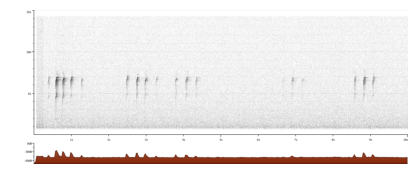

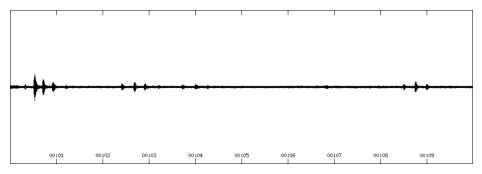

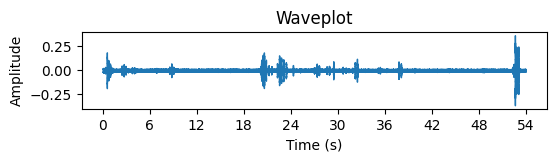

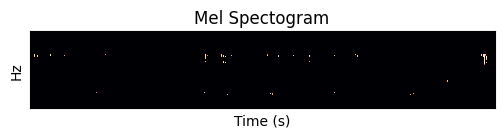

In [ ]:
def plot_image(image):
  plt.figure(figsize=(12, 2))
  plt.imshow(image)
  plt.axis('off')
  plt.show()

def get_field(page: Page, id: str, field:str, prefix=True):
  url = page.recordings.loc[id][field]
  url = f"https:{url}" if prefix else url
  return httpx.get(url).raise_for_status()

def plot_sono_xeno(page: Page, id: str, version:str='small'):
  field = 'sono.'+ version
  response = get_field(page, id, field)
  plot_image(Image.open(BytesIO(response.content)))

def plot_osci_xeno(page: Page, id: str, version:str='small'):
  field = 'osci.'+ version
  response = get_field(page, id, field)
  plot_image(Image.open(BytesIO(response.content)))

def plot_wave(path:str, sample_rate:int):

  audio, sr = librosa.load(path, sr=sample_rate)
  plt.figure(figsize=(6, 1))
  librosa.display.waveshow(audio, sr=sample_rate)
  plt.title('Waveplot')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.show()

def plot_mel(path:str, sample_rate:int, window_size = 2048, hop_size = 512, n_mels = 128):

  audio, sr = librosa.load(path, sr=sample_rate)
  stft = librosa.stft(audio, n_fft=window_size, hop_length=hop_size)
  mel_spec = librosa.feature.melspectrogram(S=librosa.amplitude_to_db(np.abs(stft)), sr=sr, n_mels=n_mels)
  log_mel_spec = librosa.power_to_db(mel_spec)

  plt.figure(figsize=(6, 1))
  librosa.display.specshow(log_mel_spec, sr=sample_rate)
  plt.title('Mel Spectogram')
  plt.xlabel('Time (s)')
  plt.ylabel('Hz')
  plt.show()


id = '310470'

plot_sono_xeno(page, id, version='large')
plot_osci_xeno(page, id, version='large')

sample_rate = int(page.recordings.loc[id].smp)
plot_wave(f"/content/data/common_blackbird_{id}.mp3", sample_rate)
plot_mel(f"/content/data/common_blackbird_{id}.mp3", sample_rate)

In [ ]:
async def _get_audio(url:str, path:str):
  async with httpx.AsyncClient() as client:

          response = await client.get(url)
          response.raise_for_status()

          with open(path, 'wb') as file:
              for chunk in response.iter_bytes():
                  file.write(chunk)



async def get_page_audio(page: Page, dir: str, ids: list[str] = None):

    os.makedirs(dir, exist_ok=True)

    if ids is None:
        ids = page.recordings.index


    total_downloads = len(ids)
    progress_bar = tqdm(total=total_downloads, unit="download", dynamic_ncols=True)

    async def download_and_track(url, path, progress_bar):
        await _get_audio(url, path)
        progress_bar.update(1)

    tasks = []
    for id in ids:

        en = (page.recordings.loc[id].en).lower().replace(" ", "_")
        file_name = page.recordings.loc[id]['file-name']
        if '.mp3' in file_name:
          path = f"{dir}/{en}_{id}.mp3"
        elif '.wav' in file_name:
          path = f"{dir}/{en}_{id}.wav"
        else:
          warnings.warn("no .mp3 or .wav suffix")

        if not os.path.exists(path):
          task = asyncio.create_task(download_and_track(page.recordings.loc[id]['file'], path, progress_bar))
          tasks.append(task)

    await asyncio.gather(*tasks)

    progress_bar.close()

#asyncio.run(get_page_audio)
await get_page_audio(page, 'data', ['312226', '310470', '308927'])

  0%|          | 0/3 [00:00<?, ?download/s]

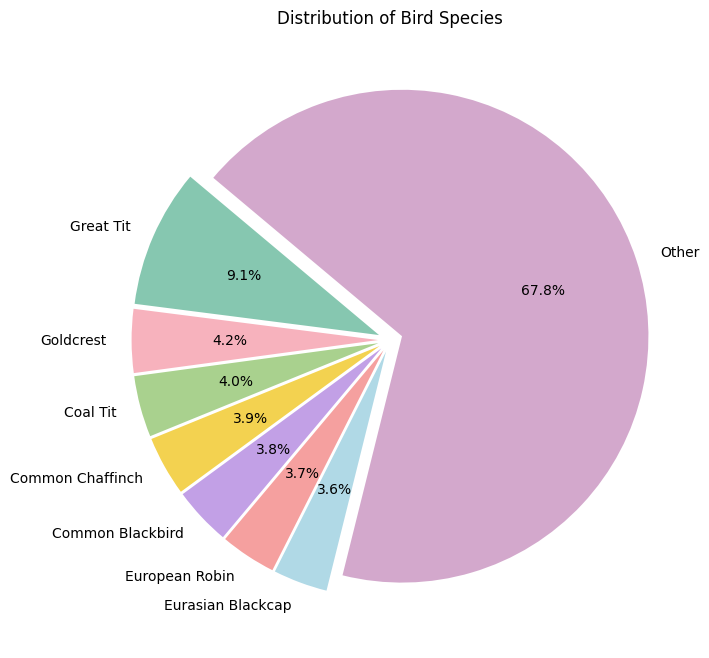

In [ ]:
import matplotlib.pyplot as plt
df = page.recordings

threshold = 3

# Count the frequency of each bird species
species_counts = df['en'].value_counts()

# Calculate the total number of bird observations
total_bird_observations = len(df)

# Calculate the percentage of each species based on total bird observations
species_percentages = species_counts / total_bird_observations * 100

# Filter species that have at least treshold representation
top_species = species_percentages[species_percentages >= threshold]

# Create a new series with "Other" category for species below the threshold
other_species_count = species_percentages[species_percentages < threshold].sum()
top_species['Other'] = other_species_count

# Create the pie chart
plt.figure(figsize=(8, 8))
colors = ['#86c7b0', '#f7b2bd', '#a9d18e', '#f3d250', '#c2a0e6', '#f5a09f', '#b0d9e6', '#d3a8cc', '#f6c85d', '#b9a2c5']
plt.pie(top_species, labels=top_species.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=[0.05]*len(top_species))
plt.title('Distribution of Bird Species')
plt.show()

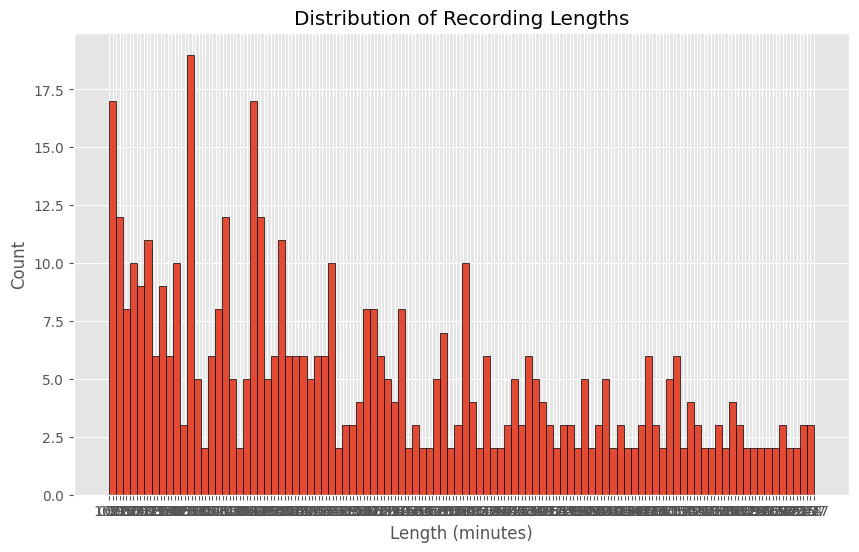

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(df['length'], bins=100, edgecolor='k')
plt.title('Distribution of Recording Lengths')
plt.xlabel('Length (minutes)')
plt.ylabel('Count')
plt.show()

In [22]:
import torch
import torch.nn as nn
from torchsummary import summary


class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(

            nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=3), #174, 18
            nn.ReLU(),
            nn.MaxPool2d((2, 1), stride=(2, 1)), #87, 18

            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1), #174, 18
            nn.ReLU(),
            nn.MaxPool2d((3, 2), stride=(3, 2)), #29, 9

            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1), #29, 9
            nn.ReLU(),
            nn.MaxPool2d((3, 1), stride=(3, 1)), #9, 9

        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(8 * 9 * 9, 128),
            nn.Dropout(0.5),
            nn.Linear(128, 5),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.features(x)
        print(x.size())
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


model = Model()
print(summary(model, input_size = (1, 345, 33)))

torch.Size([2, 8, 9, 9])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 16, 174, 18]             416
              ReLU-2          [-1, 16, 174, 18]               0
         MaxPool2d-3           [-1, 16, 87, 18]               0
            Conv2d-4           [-1, 16, 87, 18]           2,320
              ReLU-5           [-1, 16, 87, 18]               0
         MaxPool2d-6            [-1, 16, 29, 9]               0
            Conv2d-7             [-1, 8, 29, 9]           1,160
              ReLU-8             [-1, 8, 29, 9]               0
         MaxPool2d-9              [-1, 8, 9, 9]               0
          Dropout-10                  [-1, 648]               0
           Linear-11                  [-1, 128]          83,072
          Dropout-12                  [-1, 128]               0
           Linear-13                    [-1, 5]             645
          Sigm